# Overview
This script runs through sample experiment data from manually reading in raw file to preprocessing through applying filters, eye blink detection using peak finding techniques. Then we create epochs and plot evoked responses. 

In the advanced walkthrough: [walkthrough_advanced.ipynb](https://github.com/jeon11/mne-egi/blob/master/walkthrough_advanced.ipynb), we implement independent component analysis (ICA) and autoreject, which is an automated tool for fixing data, to see how the epochs are improved and compare the evoked responses by conditions. 

The script requires at least two files: 
  - the raw data [(download from Google Drive ~500MB)](https://drive.google.com/file/d/1W2UFu_6H4HzFF2DALAxfmr0BNSj7pEok/view?usp=sharing)
  - exported event text log from NetStation software

### Running the script in command line

When running the Python script from command line, MNE recommends using ipython via:

```
ipython —-pylab osx -i mne-egi-walkthrough.py
```

For Windows, instead of `osx`, you would be specifying `qt`.


### Importing

Let's begin by importing all the necessary modules. Make sure you have all the required dependencies setup.

In [1]:
import mne
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mne.preprocessing import eog
from mne.preprocessing import create_eog_epochs
from mne.preprocessing.peak_finder import peak_finder
import Tkinter
import extract_nslog_event

### Setting basic variables

Before we begin any preprocessing, we create variables here to specify what we want to look for. The whole script basically requires two main files. 
1. raw_fname: The raw instance of eeg data file in .raw format
2. ns_eventlog: Netstation's event exports in text

The `selection` variable is later used to specify which channels to plot and compare. Note, the first item in the `selection` list, `EB` channel is a virtual channel created from bipolar referene. 

In [2]:
# specify sample subject data directory
raw_fname   = '/Users/Jin/Documents/MATLAB/research/mne-egi/data/sfv_eeg_011ts.raw'
ns_eventlog = '/Users/Jin/Documents/MATLAB/research/mne-egi/data/sfv_eeg_011ts_nsevent'

# specify sub-sample of channels to look in detail
selection = ['EB','E11','E24','E124','E36','E104','E52','E62','E92']

### Reading in raw file
Raw eeg data can be read in with a simple line below. You can specify montage kind in strings. See https://martinos.org/mne/dev/generated/mne.channels.read_montage.html for available montages. We set `preload=True` because some of the preprocessing functions require raw file to be preloaded. 

Once the raw file is loaded, typing `raw` and `raw.info` will show details about the raw instance.

In [3]:
print('reading raw file...')
raw = mne.io.read_raw_egi(raw_fname, montage='GSN-HydroCel-128', preload=True)
print('Done!')

reading raw file...


<ipython-input-3-8bc42ae4bead>:2: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw = mne.io.read_raw_egi(raw_fname, montage='GSN-HydroCel-128', preload=True)


Done!


In [4]:
print(raw)
# see the first ten list of channel names (note by default, prefix 'E' is appended)
print(raw.info['ch_names'][0:10])

# see highpass & lowpass filter
print('highpass filter: ' + str(raw.info['highpass']))
print('lowpass filter: ' + str(raw.info['lowpass']))

<RawEGI  |  sfv_eeg_011ts.raw, n_channels x n_times : 136 x 989490 (4947.4 sec), ~1.00 GB, data loaded>
['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10']
highpass filter: 0.0
lowpass filter: 100.0


## Applying bandpass filter

Our first preprocessing step will be applying the bandpass filter of 1Hz and 30Hz. The numbers can be played around with, but this filter range will potentially remove general noise from environment and slow drifting signals. Other suggestions for highpass is 0.1; for 40 Hz lowpass.

After bandpass filter is applied, type `raw.info` to check how `raw.filter` made changes. 

In [5]:
# apply bandpass filter to raw file (highpass, lowpass)
raw.filter(1,30)

# see highpass & lowpass filter
print('highpass filter: ' + str(raw.info['highpass']))
print('lowpass filter: ' + str(raw.info['lowpass']))

highpass filter: 1.0
lowpass filter: 30.0


## Creating meta dataframe

We will deviate a little from processing raw file, and construct a dataframe that can be later used for effectively creating epochs or querying information we just need. This part uses the custom built module (also experiment specific as each experiment will have different paradigms and event tags). The `extract_nslog_event` constructs necessary pandas dataframe from `ns_eventlog` text file which we specified earlier in #Setting-basic-variables.

`create_df` returns five dataframes, in which nsdata is a list from simply csv-read file that is used to create task-specific pandas dataframes. For example, `df_lst` is the initial dataframe created that includes all practice, trials, and sentences tasks. The rest of dfs contain task specific data. 

In [6]:
# create pandas data frames for different tasks
nsdata, df_lst, df_plst, df_tlst, df_slst = extract_nslog_event.create_df(ns_eventlog)

creating data frame from ns event log...
dataframes created for subject 011
trials found: 800
sentences found: 200


From now on, for simplicity sake, we will only examine the actual trials task part in this walkthrough. We can focus on looking at the data structure of trials task. Since the dataframe is already created specifically for trials, what we really want now is the onset (sample numbers) of when the event occured and the condition of the stimuli that was presented. 

In [7]:
# show data frame structure of 2rd index
print(df_tlst.iloc[2])

code      tlst
label     lstS
onset    99867
cond         4
indx         1
Name: 2, dtype: object


The label for trials task was either a last word start (lstS) or last word end (lstE). Since we are interested in the onset of the word, we will extract just the onsets using the custom code. 

In [8]:
# create onset-only data frame (event tag specifications)
df_tlstS = extract_nslog_event.create_df_onset(df_tlst)
# show total events of interest
len(df_tlstS)

400

## Finding impedance check periods and annotating

Now that we have dataframes setup, we continue to clean up the raw data. Throughout the acquisition, we ran impedance checks to make sure that all electrodes were in good contact with the scalp and that good signal is being read in. During the impedance check, the waveforms peak in extreme amount and we want to make note of these periods, telling the mne functions to avoid and ignore such periods.

In [9]:
# find impedance onsets
imp_onset, imp_offset, imp_dur = extract_nslog_event.find_impedances(nsdata)

# annotate on raw with 'bad' tags (params `reject_by_annotation` will search for 'bad' tags later)
annot_imp = mne.Annotations(imp_onset, imp_dur, ["bad imp"] * len(imp_onset), orig_time=raw.info['meas_date'])
raw.set_annotations(annot_imp)

finding impedance periods...
found 4 impedance periods!


<RawEGI  |  sfv_eeg_011ts.raw, n_channels x n_times : 136 x 989490 (4947.4 sec), ~1.00 GB, data loaded>

## Marking bad channels
We also want to make note of bad channels. We can manually inspect for bad channels by seeing the actual raw data.  `raw.plot` will show the actual raw file with annotations from above marked as red segments. You can inspect for good/bad channels and manually click on bad channels to mark them bad. Once you manually inspected the channels, type `raw.info['bads']` to see how it is updated. 

Note that the plot below is a static figure for example sake. Running the code in ipython will allow us to horizontally and vertically scroll through data. Clicking on a channel will mark that channel red and be considered red. You can see that we've ran four impedance checks throughout the session (1 task switch period, every 100th trials out fo 400).

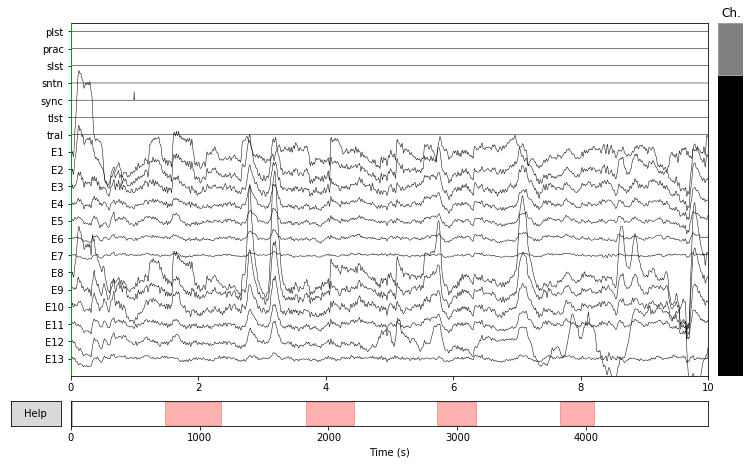

Figure(782.64x483.12)


In [10]:
# block=True is useful because it will wait to whatever change you make in the raw file at the plot stage
print(raw.plot(bad_color='red', block=True))

If you already had a list of bad channels noted during the acquisition period, you can skip the above manual inspection and simply specify the bad channels with a line of code: 

In [11]:
raw.info['bads'] = ['E127', 'E107', 'E49', 'E48', 'E115', 'E113', 'E122', 'E121', 'E123', 'E108', 'E63', 'E1']
print(raw.info['bads'])

['E127', 'E107', 'E49', 'E48', 'E115', 'E113', 'E122', 'E121', 'E123', 'E108', 'E63', 'E1']


## Detecting and rejecting eye blinks
We've so far applied generic/broad preprocessing steps, such as bandpass filters, marking chunks of bad segments, and marking bad channels. Now we will look at finding eye blinks in the raw and add more annotations to mark those samples bad. 

### Step 1: Setting bipolar reference
Because the cap we use do not have EOG-specific channels, we use the channels that are nearest to the eyes and consider those as our virtual eye channels. Thus, such method has the risk of the eye channels actually not having just the eye-related oscillations. This is done by setting the bipolar reference, which is basically the subtraction of two opposing channels (ie. the top and bottom of each eye for eye blinks; the left and right of the eyes for eye movements). 

Here, we use just the right side of the eye only to detect eye blinks. From the subtraction of channel E8 and E126, a virtual channel EB is created.

In [12]:
# let's begin eye artifact detections
print('Starting EOG artifact detection')
raw = mne.set_bipolar_reference(raw, ['E8'],['E126'],['EB'])

# specify this as the eye channel
raw.set_channel_types({'EB': 'eog'})

# double check the changes
# print(raw.info['chs'])

Starting EOG artifact detection


### Step 2: Detecting eye blinks
Now that we have a virtual eye channel to inspect, we can try to identify any eye blinks. Because the virtual eye channel that is created from subtraction of the channels, the waveform of EB channel will be generally flat. You can inspect this by `raw.plot`. 

Eye blinks are generally characterized as two eye channels having sudden opposing peaks. So the methodology is to find a sudden peak within the flat EB line. We have the options of: 

1. finding eye blinks via mne built in function
2. finding eye blinks via scipy peak finding method

Both results in similar eye blink detections because the methodology of finding local peaks. We will only use the mne built in function and comment out the custom built function that uses scipy. `reject_by_annotation` will ignore the bad segments marked as bad earlier. The threshold of 0.0001 can be played around with but it is a reasonable threshold set after having manually inspect the data. The `events_eog` will be an array with [sample number, 0, eventlabel in number]

In [13]:
events_eog = eog.find_eog_events(raw, reject_by_annotation=True, thresh=0.0001, verbose=None)

# type `help(scipy_annotate_eyeblinks)` for detail
# raw = scipy_annotate_eyeblinks(raw, 'EB', 100)

print('number of eye blinks detected: ' + str(len(events_eog)))

number of eye blinks detected: 1720


`events_eog` above will give where the eye blinks occured in samples. We will convert the sample number to seconds so we can annotate on the raw file.

In [14]:
# get just the sample numbers from the eog events
eog_sampleN = [i[0] for i in events_eog]
# convert to seconds for annotation-friendly purposes
for i in range(0, len(eog_sampleN)):
    eog_sampleN[i] = eog_sampleN[i] / float(200)
    
# set annotation
annot_eog = mne.Annotations(eog_sampleN, [0.1] * len(eog_sampleN), 
                            ["bad eye"] * len(eog_sampleN), orig_time = raw.info['meas_date'])

In [15]:
# add this eye blink annotation to the previous annotation by simply adding
new_annot = annot_imp + annot_eog
raw.set_annotations(new_annot)
print('new annotation set!')

new annotation set!


Now that new annotation is set, let's see the changes made to the raw. Again we will just have a figure printed out here. You can see the bad channels marked red (like E1), and bunch of red bars that potentially mark spikes/eye blinks. Because the Times x-axis is so zoomed out, we see all parts being red, but as we see the plot above, that is actually not true. We see that 'bad eye' is annotated for any potential peaks in the 'EB' channel that is newly created from bipolar reference. 

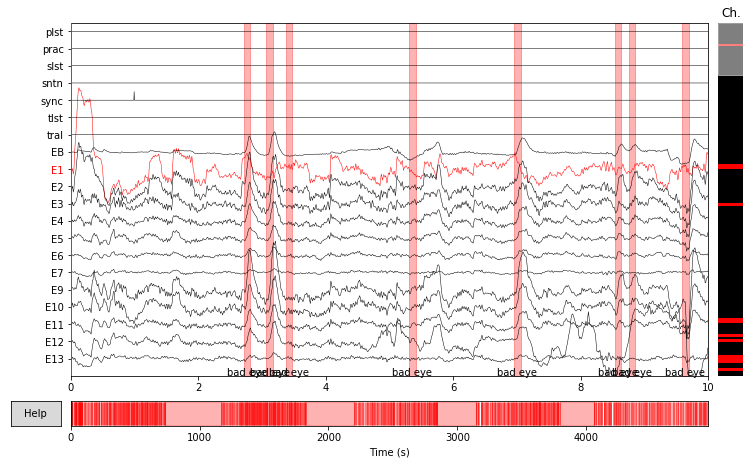

Figure(782.64x483.12)


In [16]:
# you can check that more red segments are marked on the raw file
print(raw.plot(bad_color='red'))

## Setting rereference
Now that bad channels are marked and we know which bad segments to avoid, we will set eeg reference (We want to avoid doing reference before the bad data are marked and rejected).

In [17]:
print('setting eeg reference...')
raw.set_eeg_reference('average', projection=True)

setting eeg reference...


<RawEGI  |  sfv_eeg_011ts.raw, n_channels x n_times : 135 x 989490 (4947.4 sec), ~1019.5 MB, data loaded>

## Creating epochs
Now that we have done some primary artifact detections, we can create a first look on how our epochs look. Epochs are time-locked events of interest. Here, we look at the few hundred milliseconds before and after the onset of the last word of a sentence presentation. Before creating the epochs, we will run some custom codes to update the event arrays accordingly so the event labels are properly labeled ie. 1 for onsets, 2 for offsets. 

In [18]:
# first find events related to tlst stim channel in the cleaned raw
events_tlst = mne.find_events(raw, stim_channel='tlst')

# events_tlst is a array structure ie.  (1, 0, 1) and so far, the all the event tags are 1 which is not true
# We will update the event tags with 1s and 2s with custom built function

# update event ids in mne events array and double check sampling onset timing as sanity check
events_tlstS = extract_nslog_event.assign_event_id(df_tlst, events_tlst)

updating mne event array and double checking sampling onset time...


In [19]:
# epoching initially with metadata applied
event_id_tlst = dict(lstS=1)
tmin = -0.25  # start of each epoch
tmax = 0.8  # end of each epoch
# set baseline to 0
baseline = (tmin, 0)

# picks specify which channels we are interested
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=False, exclude='bads')

# `metadata` field is used to put in our comprehensive pandas dataframe
# it is useful for later creating evoked responses by conditions
epochs_tlstS = mne.Epochs(raw, events_tlstS, event_id_tlst, tmin, tmax, proj=False, picks=picks, 
                          baseline=baseline, preload=True, reject=None, reject_by_annotation=True, metadata=df_tlstS)
print('epochs_tlstS:')
print(epochs_tlstS)

epochs_tlstS:
<Epochs  |   388 events (all good), -0.25 - 0.8 sec, baseline [-0.25, 0], ~72.8 MB, data loaded, with metadata,
 'lstS': 388>


We created epochs named `epochs_tlstS` which is mne's epochs instance. Note that the epochs are 388 instead of original 400. It is likely that the some epochs are dropped from annotations. Let's see if it's true. 

In [20]:
# show drop percentage from mne.Epochs
drop_count = 0
for j in range(0, len(epochs_tlstS.drop_log)):
    if 'bad eye' in epochs_tlstS.drop_log[j]:
        drop_count += 1
print(str(drop_count) + ' epochs dropped by eog annotation')
print('perecentage dropped: ' + str(epochs_tlstS.drop_log_stats()))

12 epochs dropped by eog annotation
perecentage dropped: 3.0


## Creating evoked response (ERP)
Everything looks good. We can create an evoked response by condition. Currently, the epochs_tlst contains all four conditions of the task. By creating an evoked response by condition, we can examine the data for each condition. 

In [21]:
# create evoked respone using pandas query based on metadata created from previous epochs
evoked_tlst_c1 = epochs_tlstS["label=='lstS' and cond=='1'"].average()
evoked_tlst_c2 = epochs_tlstS["label=='lstS' and cond=='2'"].average()
evoked_tlst_c3 = epochs_tlstS["label=='lstS' and cond=='3'"].average()
evoked_tlst_c4 = epochs_tlstS["label=='lstS' and cond=='4'"].average()

Evoked responses are created by condition. Let's just inspect the first one. The figure below will show the waveforms of all channels (except the ones marked bad and bipolar referenced channels) with total N epochs in that condition. Originally, N=100 for each condition. 

We can see something happening at 100ms to 300ms range after the onset of the word, which is time point 0s. 

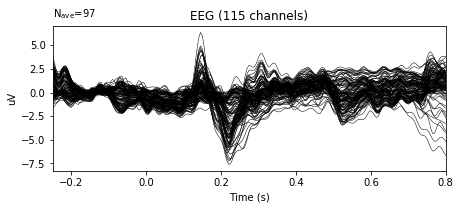

Figure(460.8x216)


In [22]:
print(evoked_tlst_c1.plot())

Figure above is in black and could be hard to inspect. A more interesting plot could be using `plot_joint` method. You can see that most of the channels in the frontal region are showing flat, insignificant patterns. On the other hand, the right occipital (marked in red, purplish colors) is revealing potentially interesting results.

/Users/Jin/Library/Python/2.7/lib/python/site-packages/mne/transforms.py:689: RuntimeWarning: invalid value encountered in divide
  out[:, 2] = np.arccos(cart[:, 2] / out[:, 0])


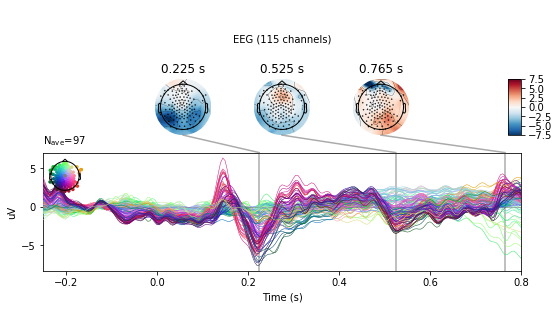

Figure(576x302.4)


In [23]:
print(evoked_tlst_c1.plot_joint(times='peaks'))

To avoid going through the same process everytime you load in a subject, we can save the progress by saving the resulted epochs (ie. `epochs_tlstS` or raw instance). In the other notebook, we will continue with more advanced artifact detection using the saved epochs.

In [24]:
epochs_tlstS.save('epochs_tlsts-epo.fif', split_size='2GB', fmt='single', verbose=True)

## Sources and useful links
MNE querying metadata: https://martinos.org/mne/stable/auto_examples/preprocessing/plot_metadata_query.html

MNE annotations: https://martinos.org/mne/stable/generated/mne.Annotations.html